In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
import sqlite3
import glob

# Set up variables and get the first year of observations

In [2]:
# select the survey simulation
baseline_db = "baseline_v3.2_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

# range of nights to investigate (year 1 of survey)
night_min = 0
night_max = 365

In [3]:
# set nside for analysis metric (use higher resolution when removing no-template images later)
# nside = 32
nside = 64
# nside = 256
s_hp = maf.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
# set path for metric output files
save_dir = "survey_coverage_results_{}".format(nside)

In [5]:
# use the healpix area to find approximate number of healpixels in a single visit
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees
lsst_footprint = 9.6 # single visit footprint, square degrees, GET EXACT NUMBER?
n_pix = lsst_footprint/pix_area # number of healpixels within each visit footprint
print("healpixel area = {} square degrees\n number of healpixels in visit = {}".format(pix_area,n_pix))

healpixel area = 0.8392936452111668 square degrees
 number of healpixels in visit = 11.438189785870039


In [6]:
# query or load the database of year 1 observations
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<=night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

In [7]:
# what are the unique descriptions of each visit
np.unique(df_year1["note"])

array(['DD:COSMOS', 'DD:ECDFS', 'DD:EDFS_a', 'DD:EDFS_b', 'DD:ELAISS1',
       'DD:XMM_LSS', 'blob_long, gr, a', 'blob_long, gr, b',
       'blob_long, iz, a', 'blob_long, iz, b', 'blob_long, ri, a',
       'blob_long, ri, b', 'greedy', 'long', 'pair_15, iz, a',
       'pair_15, iz, b', 'pair_15, ri, a', 'pair_15, ri, b',
       'pair_15, yy, a', 'pair_15, yy, b', 'pair_15, zy, a',
       'pair_15, zy, b', 'pair_33, gr, a', 'pair_33, gr, b',
       'pair_33, iz, a', 'pair_33, iz, b', 'pair_33, ri, a',
       'pair_33, ri, b', 'pair_33, ug, a', 'pair_33, ug, b',
       'pair_33, ur, a', 'pair_33, ur, b', 'pair_33, yy, a',
       'pair_33, yy, b', 'pair_33, zy, a', 'pair_33, zy, b',
       'twilight_near_sun, 0', 'twilight_near_sun, 1',
       'twilight_near_sun, 2', 'twilight_near_sun, 3'], dtype=object)

In [8]:
# Number of deep drilling (DD) visits
df_year1["note"][df_year1["note"].str.contains("DD")]

3050      DD:COSMOS
3051      DD:COSMOS
3052      DD:COSMOS
3053      DD:COSMOS
3054      DD:COSMOS
            ...    
232447    DD:COSMOS
232448    DD:COSMOS
232449    DD:COSMOS
232450    DD:COSMOS
232451    DD:COSMOS
Name: note, Length: 19791, dtype: object

In [9]:
# Does "pair" refer to WFD?
df_year1["note"][df_year1["note"].str.contains("pair")]

93        pair_33, ug, a
94        pair_33, ug, a
95        pair_33, ug, a
96        pair_33, ug, a
97        pair_33, ug, a
               ...      
239276    pair_15, yy, b
239277    pair_15, yy, b
239278    pair_15, yy, b
239279    pair_15, yy, b
239280    pair_15, yy, b
Name: note, Length: 195201, dtype: object

In [10]:
# define a string sql_qry which will be applied to the metric sql query

# no constraint
# sql_qry = ''

# Choose to ignore deep drilling fields and count everything else
sql_qry = ' and note not like "%DD%"'

# Use this string to count only the WFD?
# sql_qry = ' and note like "%pair%"'

In [11]:
len(df_year1)

239308

In [12]:
# set up some filenames
opsim_fname = year1_fname
print(opsim_fname)
# opsdb = maf.OpsimDatabase(opsim_fname)
opsdb = opsim_fname
runName = os.path.split(opsdb)[-1].replace('.db', '')
print(runName)

first_year_baseline_v3.2_10yrs.db
first_year_baseline_v3.2_10yrs


In [13]:
# query the metric repeatedly over some timescale
tscale = 28
query_nights = np.arange(tscale,night_max+tscale,tscale)
# do not query beyond night_max
query_nights[query_nights>night_max] = night_max
query_nights

array([ 28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336, 364,
       365])

In [14]:
# perform the count metric for visits up to the query night
# this means that visits counted will be cumulative

_runName = "{}_nside-{}".format(runName,nside)

bl = []
summary_stats = [maf.MedianMetric()]
    
for t_data in query_nights:

    for filt in ["all","u","g","r","i","z","y"]:

        if filt=="all":
            sql = 'night <= {}'.format(t_data)+sql_qry
        else:
            sql = 'filter = "{}" and night <= {}'.format(filt,t_data)+sql_qry
            
        print(sql)

        # Run the count metric
        metric = maf.CountMetric(col='observationStartMJD', metric_name = "CountMetric")
        bl.append(maf.MetricBundle(metric, s_hp, sql, summary_metrics=summary_stats, run_name=_runName))

mg = maf.MetricBundleGroup(bl, opsdb, out_dir=save_dir)

mg.run_all()
# mg.plot_all(closefigs=False)

night <= 28 and note not like "%DD%"
filter = "u" and night <= 28 and note not like "%DD%"
filter = "g" and night <= 28 and note not like "%DD%"
filter = "r" and night <= 28 and note not like "%DD%"
filter = "i" and night <= 28 and note not like "%DD%"
filter = "z" and night <= 28 and note not like "%DD%"
filter = "y" and night <= 28 and note not like "%DD%"
night <= 56 and note not like "%DD%"
filter = "u" and night <= 56 and note not like "%DD%"
filter = "g" and night <= 56 and note not like "%DD%"
filter = "r" and night <= 56 and note not like "%DD%"
filter = "i" and night <= 56 and note not like "%DD%"
filter = "z" and night <= 56 and note not like "%DD%"
filter = "y" and night <= 56 and note not like "%DD%"
night <= 84 and note not like "%DD%"
filter = "u" and night <= 84 and note not like "%DD%"
filter = "g" and night <= 84 and note not like "%DD%"
filter = "r" and night <= 84 and note not like "%DD%"
filter = "i" and night <= 84 and note not like "%DD%"
filter = "z" and night <=

# Load the metric data and analyse

In [15]:
# count the total "unique" area or the total area of all observed visits?
footprint_area = {}

for filt in ["all","u","g","r","i","z","y"]:
    
    # get metric files
    if filt=="all":
        files = glob.glob("{}/*CountMetric_night_lt*npz".format(save_dir)) # select only metric files where all filters where considered
    else:
        files = glob.glob("{}/*CountMetric_{}*npz".format(save_dir,filt)) # go through all metric files for all filters
    files.sort()
    
    footprint_area[filt] = {}
    
    for f in files:
        print(f)
        
        # get the query night from file name
        n = f.split("night_lt_")[-1].split("_")[0]
        
        m = maf.MetricBundle.load(f)
        data = m.metric_values.data
        mask = m.metric_values.mask
        
        # find the number of healpixels that have some value (i.e. observed at least once)
        print(len(data[~mask]))
        footprint_area[filt][n] = len(data[~mask]) * pix_area


survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_night_lt_112_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
24897
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_night_lt_112_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
24854
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_night_lt_140_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
28137
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_night_lt_140_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
28137
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_night_lt_168_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29658
survey_coverage_results_64/first_year_baseline_v

29358
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_u_and_night_lt_336_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29434
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_u_and_night_lt_336_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29434
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_u_and_night_lt_364_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29475
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_u_and_night_lt_364_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29475
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_u_and_night_lt_365_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29475
survey_cover

29320
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_r_and_night_lt_224_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29319
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_r_and_night_lt_252_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
31964
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_r_and_night_lt_252_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
31964
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_r_and_night_lt_280_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
32905
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_r_and_night_lt_280_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminut

22186
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_z_and_night_lt_112_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
22142
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_z_and_night_lt_140_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
24823
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_z_and_night_lt_140_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
24819
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_z_and_night_lt_168_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
26750
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_z_and_night_lt_168_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminut

29714
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_y_and_night_lt_364_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29714
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_y_and_night_lt_365_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29721
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
29721
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_y_and_night_lt_56_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
16447
survey_coverage_results_64/first_year_baseline_v3_2_10yrs_nside-64_CountMetric_y_and_night_lt_56_and_note_not_like_DD_HEAL.npz
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes

In [16]:
len(data[~mask])

19503

In [17]:
data[~mask]

array([1., 1., 1., ..., 2., 2., 2.])

In [18]:
len(data[data>0])

45958

In [19]:
# inspect the filter, area dict
# note that not all entries are in night order...
footprint_area

{'all': {'112': 20859.80425807834,
  '140': 23615.2052953066,
  '168': 24891.770929672784,
  '196': 25714.27870197973,
  '224': 27103.309684804208,
  '252': 27711.797577582303,
  '280': 27937.56756814411,
  '28': 13934.792391441002,
  '308': 27982.88942498551,
  '336': 27999.675297889735,
  '364': 28012.264702567903,
  '365': 28014.782583503536,
  '56': 16352.797383294374,
  '84': 18806.892001891825},
 'u': {'112': 13668.736305909062,
  '140': 15322.984080620272,
  '168': 16348.600915068318,
  '196': 17578.166105302676,
  '224': 19243.324697401633,
  '252': 21520.32835685953,
  '280': 23571.56202575562,
  '28': 7054.263087999857,
  '308': 24639.982836109433,
  '336': 24703.769153145484,
  '364': 24738.180192599142,
  '365': 24738.180192599142,
  '56': 9692.163014898553,
  '84': 11841.594040284352},
 'g': {'112': 14853.81893294723,
  '140': 16985.624791783594,
  '168': 18061.599244944307,
  '196': 20460.300482957824,
  '224': 23372.64943184057,
  '252': 25072.219063393186,
  '280': 2746

all 365 28014.782583503536
u 365 24738.180192599142
g 365 27809.994934072012
r 365 27873.78125110806
i 365 27912.388758787773
z 365 27898.120766819186
y 365 24944.64642932109


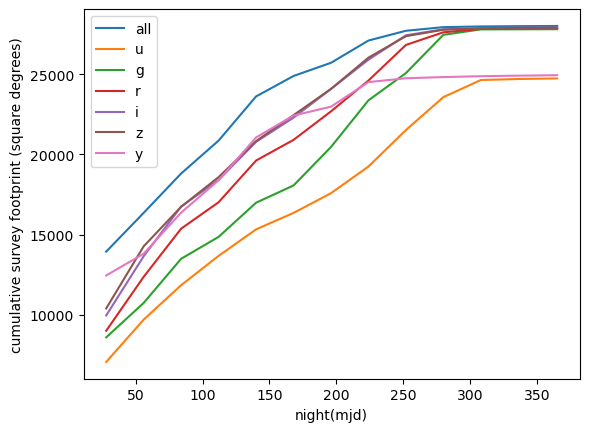

In [20]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0])


for filt in ["all","u","g","r","i","z","y"]:
    
    # ensure that the nights and areas are correctly sorted in time
    area = np.array(list(footprint_area[filt].values()))
    nights = np.array(list(footprint_area[filt].keys())).astype(float)
    sort_mask  = np.argsort(nights)

    ax1.plot(nights[sort_mask], area[sort_mask], label = filt)
    
    print(filt,night_max,footprint_area[filt][str(night_max)])

ax1.set_xlabel("night(mjd)")
ax1.set_ylabel("cumulative survey footprint (square degrees)")
ax1.legend()

plt.show()